In [94]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
import xgboost as xgb
from sklearn import svm
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler

from imblearn.under_sampling import RandomUnderSampler

from scikeras.wrappers import KerasClassifier
from keras.utils import np_utils
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc, roc_curve

In [2]:
import plotly
import kaleido

In [3]:
#%% Function to extract code from GitHub:
import requests

def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__ML_usefull = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/04_Python_ML.py'
GetGitHubCode(GitUrl__ML_usefull)

GitUrl__ANN_Keras_functions = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/ANN_Keras_functions.py'
GetGitHubCode(GitUrl__ANN_Keras_functions)

In [5]:
def plot_confusion_matrix(y_test, y_hat, model, class_names):
    cm = confusion_matrix(y_test, y_hat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=class_names)
    
    fig, ax = plt.subplots(figsize=(12,10))
    disp.plot(ax=ax)
    plt.rcParams["font.size"] = "11"
    plt.xlabel('Predicted label', fontsize=14)
    plt.ylabel('True label', fontsize=14)
    plt.show()

In [6]:
def mulit_class_results_df(model_fitted, pred_proba):
    
    '''
    return 2 df, 1-st with sorted pred_proba
               , second with sorted labels related to probas
    '''
    
    
    top_n_lables_idx = np.argsort(-pred_proba, axis=1)
    top_n_probs = np.round(-np.sort(-pred_proba),3)
    #top_n_lables_idx = np.argsort(-pred_proba, axis=1)[:, :n]
    #top_n_probs = np.round(-np.sort(-pred_proba),3)[:, :n]
    top_n_labels = [model_fitted.classes_[i] for i in top_n_lables_idx]

    #results = list(zip(top_n_labels, top_n_probs))
    # pd.DataFrame(results, columns = ['labels_sorted', 'prob_sorted'])
    
    return pd.DataFrame(top_n_probs), pd.DataFrame(top_n_labels)

In [7]:
# Set up folder with data:
os.chdir('D:\\00_PROJECTS_sripts_code\\loT_intrusion_detection')

In [8]:
###################
#%% Read data
###################

In [9]:
analysis_data = pd.read_csv('analysis_data_IoT_Intrusion.csv')                          

In [10]:
# extract mapping values
maping_labals = analysis_data[['attact_type_main_num', 'attact_type_main']]\
                    .drop_duplicates()\
                    .sort_values('attact_type_main_num')

maping_labals = dict(zip(maping_labals['attact_type_main_num'],maping_labals['attact_type_main']))

maping_labals

{0: 'Benign',
 1: 'BruteForce',
 2: 'DDoS',
 3: 'DoS',
 4: 'Mirai',
 5: 'Recon',
 6: 'Spoofing',
 7: 'Web'}

In [11]:
analysis_data.drop('attact_type_main', axis=1, inplace=True)

In [12]:
##########################################################
##########################################################
#%% Analysis data - prepare for analysis
##########################################################
##########################################################

In [13]:
##########################################################
#%% Train-Test Set

In [14]:
y_name = 'attact_type_main_num'

In [15]:
X = analysis_data.drop(y_name, axis=1)
y = analysis_data[[y_name]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
# stratify=y garantie the same 'y' distribution

In [16]:
##########################################################
#%% Undersampling training data

<AxesSubplot:xlabel='attact_type_main_num'>

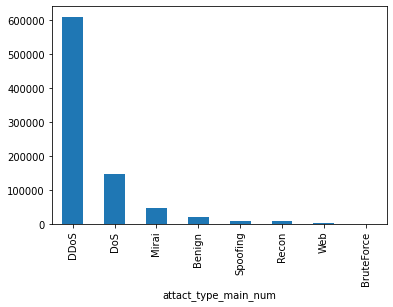

In [17]:
y_train[y_name].replace(maping_labals).value_counts().plot(kind='bar')

In [18]:
y_train[y_name].replace(maping_labals).value_counts()

attact_type_main_num
DDoS          610820
DoS           145185
Mirai          47386
Benign         19581
Spoofing        8843
Recon           6356
Web              430
BruteForce       259
Name: count, dtype: int64

In [19]:
X_y_train = pd.concat([X_train.reset_index(drop = True),
                       y_train.reset_index(drop = True)], axis = 1)

In [20]:
desired_level = 19581
resample_df = []


for label in X_y_train.attact_type_main_num.unique():
    df_for_label = X_y_train.query(f'{y_name} == @label')
    if len(df_for_label) >= desired_level:
        resample_df.append( df_for_label.sample(desired_level) )
    else:
        resample_df.append( df_for_label )

resample_df = pd.concat(resample_df)

print(resample_df[y_name].value_counts())

attact_type_main_num
2    19581
3    19581
4    19581
0    19581
6     8843
5     6356
7      430
1      259
Name: count, dtype: int64


In [21]:
X_train = resample_df.drop(y_name, axis=1)
y_train = resample_df[[y_name]]

In [22]:
# # define underampler
# rus = RandomUnderSampler(random_state=0)
#
# # fit random-under-sampler
# rus.fit(X_train, y_train)
#
# # make resampling
# X_train, y_train = rus.fit_resample(X_train, y_train)

<AxesSubplot:xlabel='attact_type_main_num'>

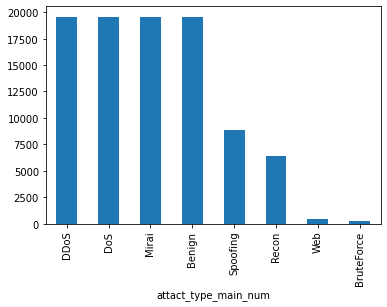

In [23]:
y_train[y_name].replace(maping_labals).value_counts().plot(kind='bar')

In [24]:
##########################################################
#%% scale data for some models

In [25]:
X_train_sld = StandardScaler().fit(X_train).transform(X_train.astype(float))
X_test_sld = StandardScaler().fit(X_test).transform(X_test.astype(float))

In [26]:
##########################################################
##########################################################
#%% Logistic Regression
##########################################################
##########################################################

In [27]:
##########################################################
#%% Train model - hyperparameter tunning
##########################################################

In [28]:
# Define parameters set
lr_param_grid = { 'C': [0.01, 0.01, 0.1, 1.0, 10, 100]
                 , 'penalty': ['l1','l2']
                 }

# Instantiate model
#model_lr_init = LogisticRegression(solver = 'liblinear')
# one-vs-rest
model_lr_init = LogisticRegression(multi_class='ovr', solver = 'liblinear')

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_lr_random_search = RandomizedSearchCV(param_distributions = lr_param_grid,
                                            estimator = model_lr_init,
                                            scoring = 'f1_macro',
                                            n_iter = 50,
                                            cv = 4,
                                            verbose=1,
                                            n_jobs=None)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_lr_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_lr_random_search.best_params_)

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 4 folds for each of 12 candidates, totalling 48 fits


C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number 

Best parameters found:  {'penalty': 'l1', 'C': 10}


C:\Users\kamil\anaconda3\lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


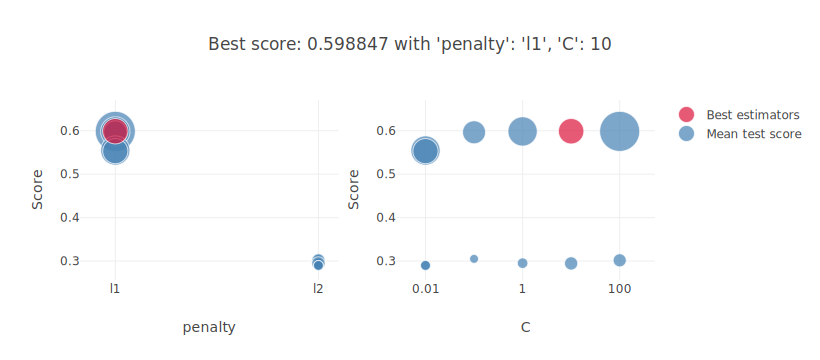

In [78]:
plot_grid_search(model_lr_random_search, for_github = True)
#table_grid_search(model_xgboost_random_search)

In [30]:
# Extract the best model
model_lr = model_lr_random_search.best_estimator_

In [31]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [32]:
preds_lr = model_lr.predict(X_test)
predict_proba_lr = model_lr.predict_proba(X_test)

preds_df_lr = pd.DataFrame(preds_lr, columns = ['y_hat'])

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



              precision    recall  f1-score   support

      Benign       0.65      0.93      0.77      4895
  BruteForce       1.00      0.28      0.43        65
        DDoS       0.96      0.65      0.77    152705
         DoS       0.38      0.87      0.53     36296
       Mirai       1.00      0.99      0.99     11847
       Recon       0.40      0.50      0.45      1589
    Spoofing       0.63      0.49      0.55      2210
         Web       0.00      0.00      0.00       108

    accuracy                           0.71    209715
   macro avg       0.63      0.59      0.56    209715
weighted avg       0.85      0.71      0.74    209715


AUC score:   0.958

Confusion Matrix:


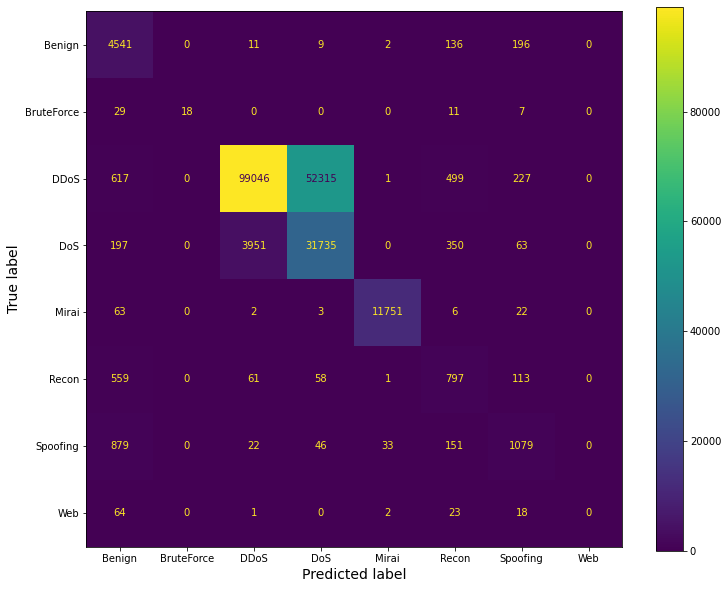

In [33]:
# Print the classification report
print(classification_report(y_test, preds_df_lr , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_lr, multi_class='ovr'), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_lr, model_lr, list(maping_labals.values())) 

In [34]:
##########################################################
##########################################################
#%% kNN
##########################################################
##########################################################

In [35]:
##########################################################
#%% Train model - hyperparameter tunning
##########################################################

In [36]:
# Define parameters set
knn_param_grid = { 'n_neighbors' : [7, 9,11, 13, 15,17,19,21, 23, 25],
                   'weights' : ['uniform','distance'],
                   'metric' : ['minkowski','euclidean','manhattan']}

# Instantiate model
model_knn_init = KNeighborsClassifier()

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_knn_random_search = RandomizedSearchCV(param_distributions = knn_param_grid,
                                              estimator = model_knn_init,
                                              scoring = 'f1_macro',
                                              n_iter = 50,
                                              cv = 4,
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_knn_random_search.fit(X_train_sld, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_knn_random_search.best_params_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'weights': 'distance', 'n_neighbors': 9, 'metric': 'manhattan'}


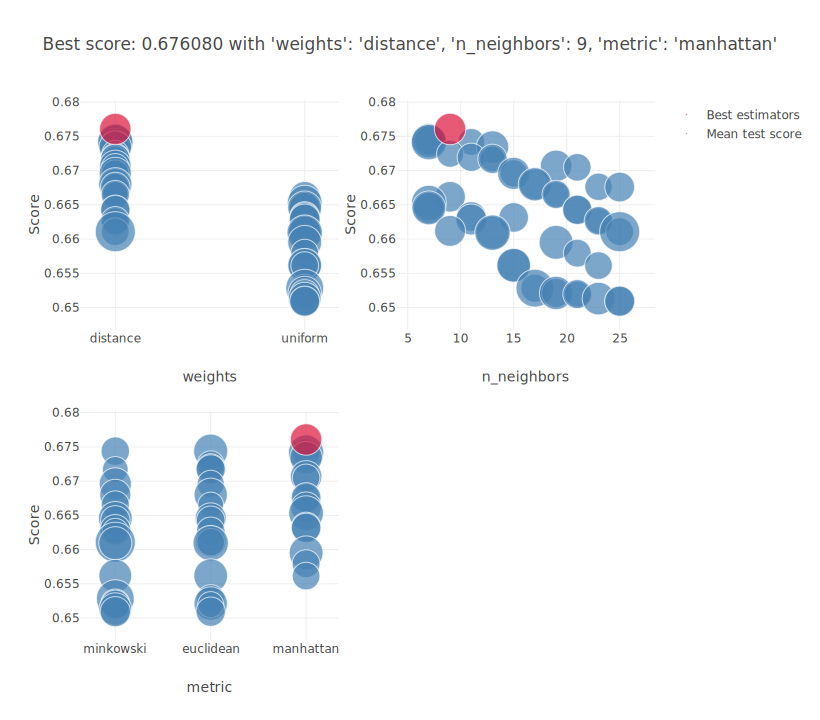

In [37]:
# plot parameters and scores
plot_grid_search(model_knn_random_search, for_github = True)

In [38]:
# Extract the best model
model_knn = model_knn_random_search.best_estimator_

In [39]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [40]:
preds_knn = model_knn.predict(X_test_sld)
predict_proba_knn = model_knn.predict_proba(X_test_sld)

preds_df_knn = pd.DataFrame(preds_knn, columns = ['y_hat'])

              precision    recall  f1-score   support

      Benign       0.65      0.81      0.72      4895
  BruteForce       1.00      0.28      0.43        65
        DDoS       0.97      0.56      0.71    152705
         DoS       0.32      0.84      0.47     36296
       Mirai       0.73      0.92      0.82     11847
       Recon       0.62      0.44      0.52      1589
    Spoofing       0.23      0.55      0.32      2210
         Web       0.06      0.01      0.02       108

    accuracy                           0.63    209715
   macro avg       0.57      0.55      0.50    209715
weighted avg       0.83      0.63      0.67    209715


AUC score:   0.824

Confusion Matrix:


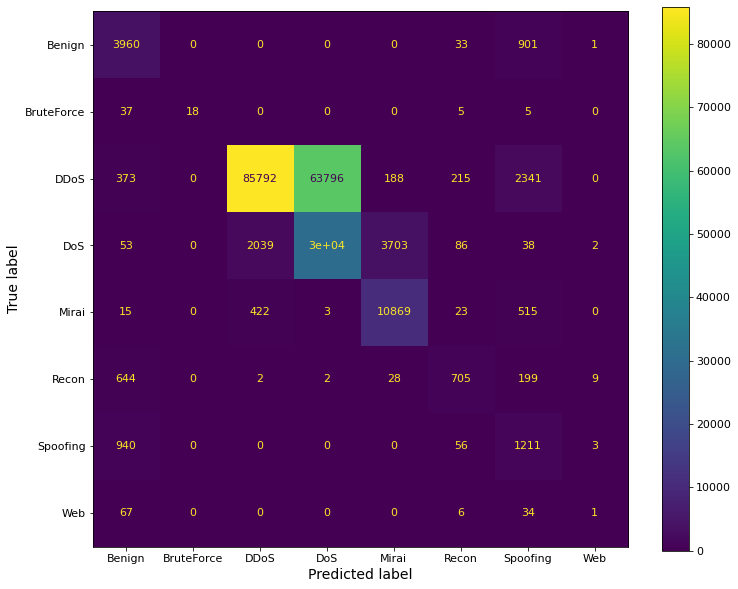

In [41]:
# Print the classification report
print(classification_report(y_test, preds_df_knn , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_knn, multi_class='ovr'), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_knn, model_knn, list(maping_labals.values())) 

In [42]:
##########################################################
##########################################################
#%% XGBoost
##########################################################
##########################################################

In [43]:
# Define parameters set
xgboost_param_grid = {
                  'n_estimators': [  200, 250,  300, 350, 400, 450, 500],
                  'max_depth': range(2, 9),
                  'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
                  'colsample_bytree': [0.3, 0.5, 0.7, 0.9, 1.0],
                  'learning_rate': [ 0.01, 0.05, 0.1, 0.3, 0.5, 0.7],
                  'gamma': [0, 0.25, 0.5, 1.0, 1.5, 2.0, 2.5],
                  'reg_lambda': [0.01, 0.05, 0.1, 0.3, 0.5, 0.75, 1.0],
                  'min_child_weight':[0.01, 0.05, 0.1, 1, 3]
                 }

# Instantiate model
model_xgboost_init = xgb.XGBClassifier()

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

# roc_auc, recall, f1_macro
model_xgboost_random_search = RandomizedSearchCV(param_distributions = xgboost_param_grid,
                                                  estimator = model_xgboost_init,
                                                  scoring = 'f1_macro',
                                                  n_iter = 50,
                                                  cv = 4,
                                                  verbose=1,
                                                  n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_xgboost_random_search.fit(X_train, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_xgboost_random_search.best_params_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits
Best parameters found:  {'subsample': 1.0, 'reg_lambda': 0.75, 'n_estimators': 450, 'min_child_weight': 0.01, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 2.0, 'colsample_bytree': 0.9}


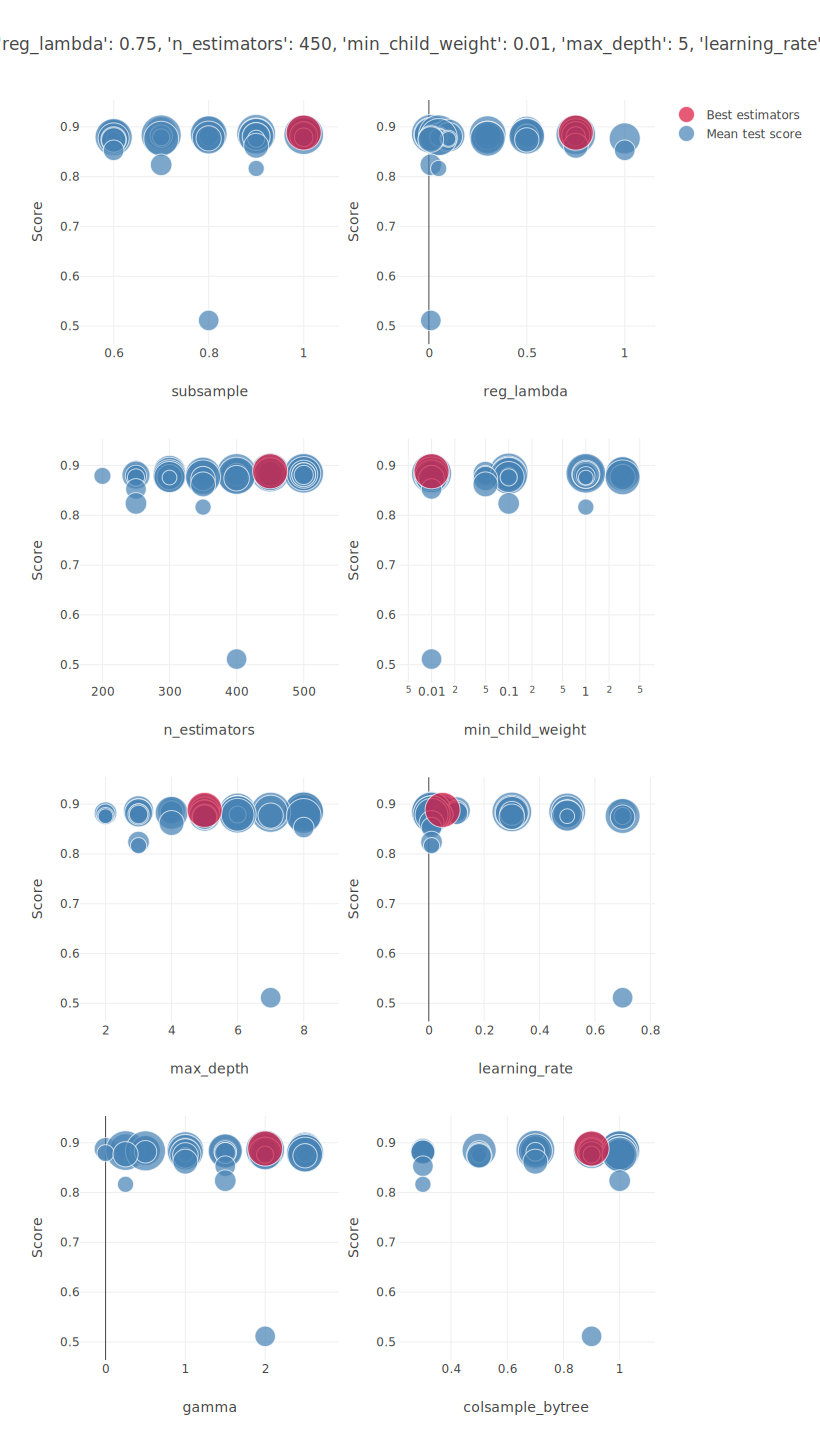

In [44]:
# plot parameters and scores
plot_grid_search(model_xgboost_random_search, for_github = True)

In [45]:
# Extract the best model
model_xgboost = model_xgboost_random_search.best_estimator_

In [46]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [47]:
preds_xgboost = model_xgboost.predict(X_test)
predict_proba_xgboost = model_xgboost.predict_proba(X_test)

preds_df_xgboost = pd.DataFrame(preds_xgboost, columns = ['y_hat'])

              precision    recall  f1-score   support

      Benign       0.91      0.98      0.94      4895
  BruteForce       1.00      0.57      0.73        65
        DDoS       1.00      1.00      1.00    152705
         DoS       1.00      1.00      1.00     36296
       Mirai       1.00      1.00      1.00     11847
       Recon       0.87      0.84      0.86      1589
    Spoofing       0.92      0.84      0.88      2210
         Web       0.98      0.60      0.75       108

    accuracy                           1.00    209715
   macro avg       0.96      0.85      0.89    209715
weighted avg       1.00      1.00      1.00    209715


AUC score:   1.0

Confusion Matrix:


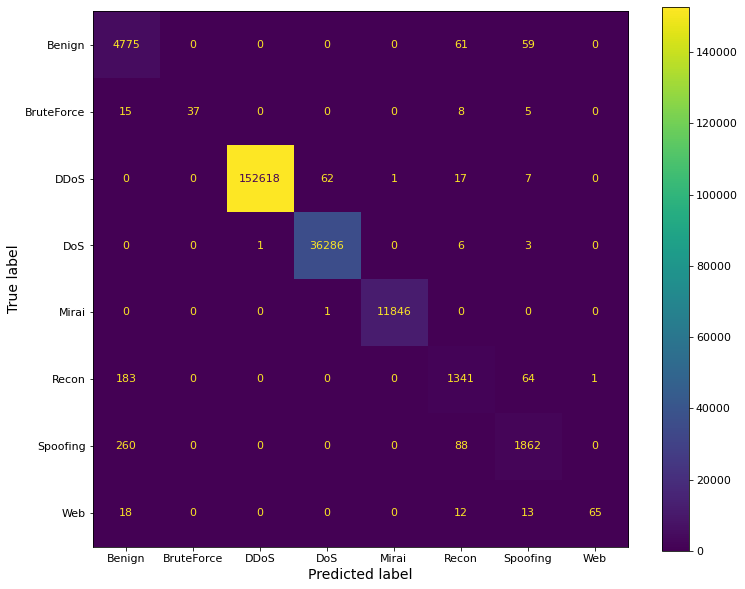

In [48]:
# Print the classification report
print(classification_report(y_test, preds_df_xgboost , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_xgboost, multi_class='ovr'), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_xgboost, model_xgboost, list(maping_labals.values())) 

In [49]:
##########################################################
##########################################################
#%% SVM
##########################################################
##########################################################

In [50]:
# Define parameters set
svm_param_grid = {
                 # 'kernel': ['rbf','poly','sigmoid'],
                  'kernel': ['rbf'],
                  'C': [ 1000, 3000, 5000, 7000, 9000, 11000],
                  'gamma': [0.001, 0.005, 0.01,  0.05],
                  #'epsilon': [0.5, 0.3, 0.1, 0.08],
                  #'degree':[3,4,5]
                 }

# Instantiate model
model_svm_init = svm.SVC(probability=True)

## in case of GridSeach:  param_grid no param_distributions

# Perform random search with CV for time series

#
model_svm_random_search = RandomizedSearchCV(param_distributions = svm_param_grid,
                                              estimator = model_svm_init,
                                              scoring = 'f1_macro',
                                              n_iter = 50,
                                              cv = 4,
                                              verbose=1,
                                              n_jobs=-1)

## in case of GridSeach:  param_grid no param_distributions

# Fit randomized_mse to the data
model_svm_random_search.fit(X_train_sld, np.ravel(y_train))

# Print the best parameters
print("Best parameters found: ", model_svm_random_search.best_params_)

C:\Users\kamil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning:

The total space of parameters 24 is smaller than n_iter=50. Running 24 iterations. For exhaustive searches, use GridSearchCV.



Fitting 4 folds for each of 24 candidates, totalling 96 fits
Best parameters found:  {'kernel': 'rbf', 'gamma': 0.01, 'C': 11000}


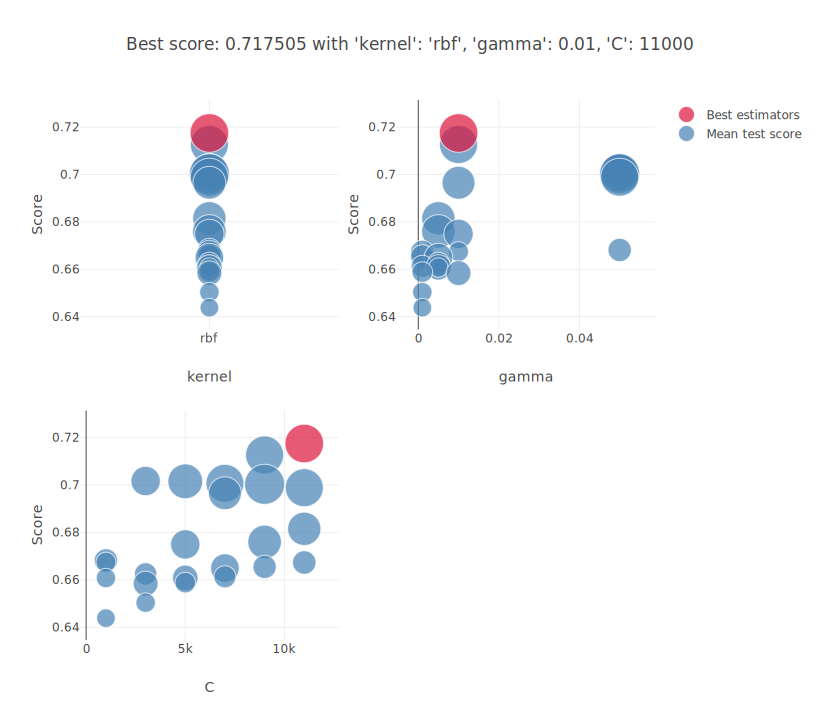

In [51]:
# plot parameters and scores
plot_grid_search(model_svm_random_search, for_github = True)

In [52]:
# Extract the best model
model_svm = model_svm_random_search.best_estimator_

In [53]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [54]:
preds_svm = model_svm.predict(X_test_sld)
predict_proba_svm = model_svm.predict_proba(X_test_sld)

preds_df_svm = pd.DataFrame(preds_svm, columns = ['y_hat'])

              precision    recall  f1-score   support

      Benign       0.06      0.01      0.01      4895
  BruteForce       0.00      0.00      0.00        65
        DDoS       0.99      0.47      0.64    152705
         DoS       0.33      0.85      0.48     36296
       Mirai       0.64      0.97      0.78     11847
       Recon       0.00      0.05      0.01      1589
    Spoofing       0.25      0.39      0.30      2210
         Web       0.02      0.81      0.03       108

    accuracy                           0.55    209715
   macro avg       0.29      0.44      0.28    209715
weighted avg       0.82      0.55      0.60    209715


AUC score:   0.628

Confusion Matrix:


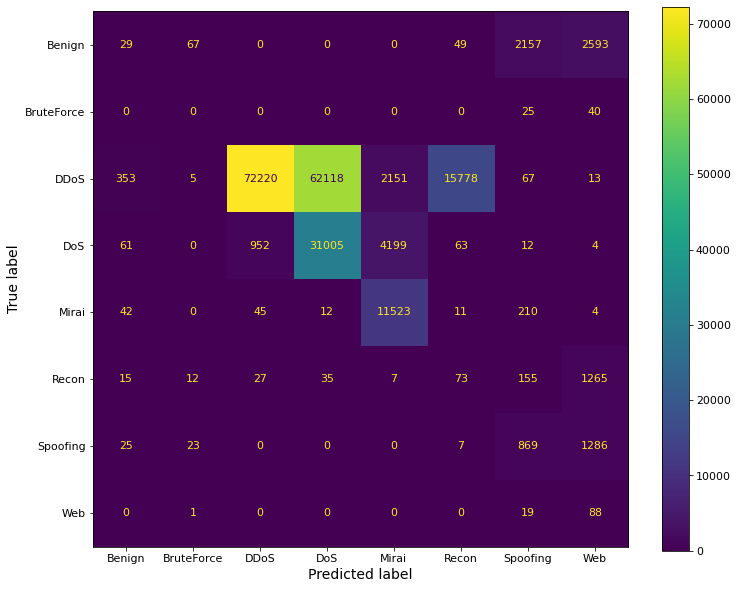

In [55]:
# Print the classification report
print(classification_report(y_test, preds_df_svm , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_svm, multi_class='ovr', average="macro"), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_svm, model_svm, list(maping_labals.values())) 

In [56]:
##########################################################
##########################################################
#%% ANN
##########################################################
##########################################################

In [57]:
# one-hot encoding y data

yohe = np_utils.to_categorical(y)
yohe_train = np_utils.to_categorical(y_train)
yohe_test = np_utils.to_categorical(y_test)

In [58]:
# Define parameters set
ann_param_grid = dict(epochs = [10,20,30,50,70,90,110],
                      batch_size = [10,20,40, 60,80],
                      model__loss = ['categorical_crossentropy'],
                      model__optimizer = ['adam','nadam'],
                      model__neurons_nr = [25, 50, 150, 200, 250],
                      model__hidden_layers_nr = [1,2,3,4,5],
                      model__input_shape = [(X_train_sld.shape[1], )],
                      model__output_nodes_nr = [8],                      
                      model__add_batch_norm = [False, True],
                      model__activation_fun = ['relu', 'LeakyReLU', 'ELU', 'swish'],
                      model__activation_out = ['softmax'],
                      model__dropout = [0.0, 0.1, 0.2, 0.3],
                      model__init = ['glorot_uniform','normal'],
                      model__regression_type = [False])

In [59]:
# Define wrapper
wraped_ann_model = KerasClassifier(model = create_feed_forward_model)

# Search hyperparamers
model_ann_random_search = RandomizedSearchCV(param_distributions = ann_param_grid,
                                            estimator = wraped_ann_model,
                                            scoring = 'f1_macro',
                                            n_iter = 50,
                                            cv = 4,
                                            verbose=1,
                                            n_jobs=-1)

model_ann_random_search.fit( X_train_sld, yohe_train )

# Print the best parameters
print("Best parameters found: ", model_ann_random_search.best_params_)

Fitting 4 folds for each of 50 candidates, totalling 200 fits


C:\Users\kamil\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/70
4711/4711 [==============================] - 17s 3ms/step - loss: 0.5086 - accuracy: 0.7804 - auc: 0.9792
Epoch 2/70
4711/4711 [==============================] - 15s 3ms/step - loss: 0.4446 - accuracy: 0.7990 - auc: 0.9837
Epoch 3/70
4711/4711 [==============================] - 16s 3ms/step - loss: 0.4297 - accuracy: 0.8037 - auc: 0.9847
Epoch 4/70
4711/4711 [==============================] - 15s 3ms/step - loss: 0.4199 - accuracy: 0.8122 - auc: 0.9854
Epoch 5/70
4711/4711 [==============================] - 15s 3ms/step - loss: 0.4135 - accuracy: 0.8156 - auc: 0.9858
Epoch 6/70
4711/4711 [==============================] - 16s 3ms/step - loss: 0.4078 - accuracy: 0.8188 - auc: 0.9862
Epoch 7/70
4711/4711 [==============================] - 15s 3ms/step - loss: 0.4044 - accuracy: 0.8197 - auc: 0.9864
Epoch 8/70
4711/4711 [==============================] - 16s 3ms/step - loss: 0.4038 - accuracy: 0.8223 - auc: 0.9867
Epoch 9/70
4711/4711 [==============================] - 15s 3ms/

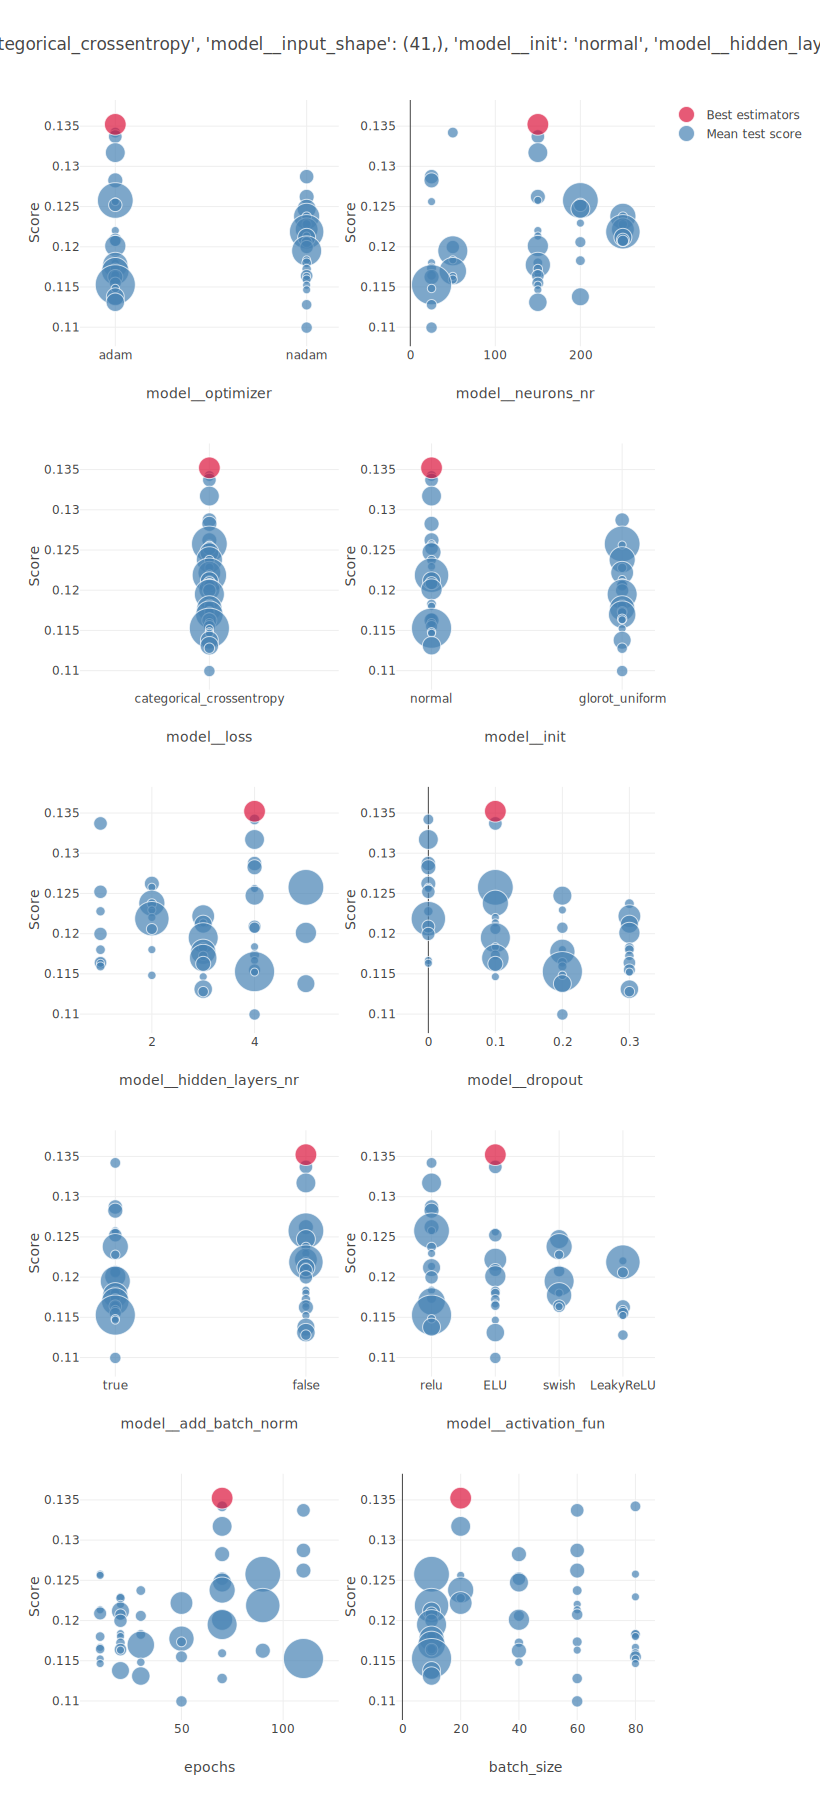

In [83]:
# plot parameters and scores
plot_grid_search(model_ann_random_search, for_github = True)

In [61]:
# Extract the best model
model_ann = model_ann_random_search.best_estimator_

In [62]:
##########################################################
#%% Test set - model evaluation
##########################################################

In [63]:
preds_ann = np.argmax(model_ann.predict(X_test_sld), axis=1)
predict_proba_ann = model_ann.predict_proba(X_test_sld)

preds_df_ann = pd.DataFrame(preds_ann, columns = ['y_hat'])

10486/10486 [==============================] - 13s 1ms/step


              precision    recall  f1-score   support

      Benign       0.77      0.87      0.82      4895
  BruteForce       0.95      0.28      0.43        65
        DDoS       0.94      0.55      0.69    152705
         DoS       0.38      0.37      0.38     36296
       Mirai       0.22      0.99      0.35     11847
       Recon       0.03      0.36      0.05      1589
    Spoofing       0.54      0.78      0.64      2210
         Web       0.05      0.03      0.04       108

    accuracy                           0.55    209715
   macro avg       0.48      0.53      0.42    209715
weighted avg       0.79      0.55      0.62    209715


AUC score:   0.882

Confusion Matrix:


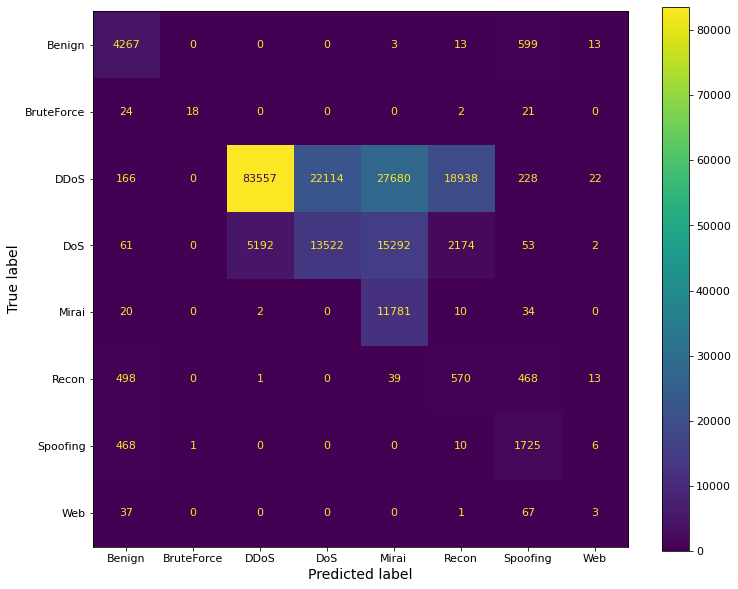

In [64]:
# Print the classification report
print(classification_report(y_test, preds_df_ann , target_names = list(maping_labals.values())))

### AUC score
print('')
print('AUC score:   ' + str(round(roc_auc_score(y_test, predict_proba_ann, multi_class='ovr', average="macro"), 3) ) )

### Confusion Matrix
print('')
print('Confusion Matrix:')
plot_confusion_matrix(y_test, preds_df_ann, model_ann, list(maping_labals.values())) 

In [65]:
##########################################################
##########################################################
#%% COMPARE MODELS
##########################################################
##########################################################

In [89]:
def plot_roc_curve(y_test, y_pred):
  
  n_classes = len(np.unique(y_test))
  y_test = label_binarize(y_test, classes=np.arange(n_classes))
  y_pred = label_binarize(y_pred, classes=np.arange(n_classes))

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  
  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # First aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

  # Finally average it and compute AUC
  mean_tpr /= n_classes

  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

  return fpr["macro"], tpr["macro"]


  # Plot all ROC curves
  #plt.figure(figsize=(10,5))
  #plt.figure(dpi=600)
  #lw = 2
#  plt.plot(fpr["micro"], tpr["micro"],
#    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
 #   color="deeppink", linestyle=":", linewidth=4,)

  #plt.plot(fpr["macro"], tpr["macro"],
  #  label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
  #  color="navy", linestyle=":", linewidth=4,)


  #plt.plot([0, 1], [0, 1], "k--", lw=lw)
  #plt.xlim([0.0, 1.0])
  #plt.ylim([0.0, 1.05])
  #plt.xlabel("False Positive Rate")
  #plt.ylabel("True Positive Rate")
  #plt.title("Receiver Operating Characteristic (ROC) curve")
  #plt.legend()

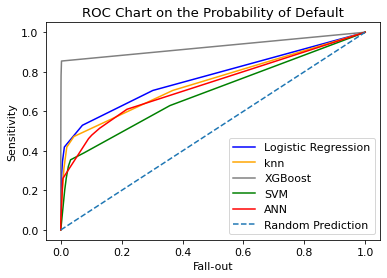

In [93]:
# ROC chart components
fpr_lr, tpr_lr = plot_roc_curve(y_test, preds_df_lr)
fpr_knn, tpr_knn = plot_roc_curve(y_test, preds_df_knn)
fpr_xgboost, tpr_xgboost = plot_roc_curve(y_test, preds_df_xgboost)
fpr_svm, tpr_svm = plot_roc_curve(y_test, preds_df_svm)
fpr_ann, tpr_ann = plot_roc_curve(y_test, preds_df_ann)



# ROC Chart with both
plt.plot(fpr_lr, tpr_lr, color = 'blue', label='%s' % 'Logistic Regression')
plt.plot(fpr_knn, tpr_knn, color = 'orange', label='%s' % 'knn')
plt.plot(fpr_xgboost, tpr_xgboost, color = 'grey', label='%s' % 'XGBoost')
plt.plot(fpr_svm, tpr_svm, color = 'green', label='%s' % 'SVM')
plt.plot(fpr_ann, tpr_ann, color = 'red', label='%s' % 'ANN')

plt.plot([0, 1], [0, 1], linestyle='--', label='%s' % 'Random Prediction')
plt.title("ROC Chart on the Probability of Default")
plt.xlabel('Fall-out')
plt.ylabel('Sensitivity')
plt.legend()
plt.show()